<a href="https://colab.research.google.com/github/abalaji-blr/ACGAN/blob/master/ACGAN_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ACGAN ( Auxilary Classifier Generative Adversarial Network)

In [1]:
!nvidia-smi

Fri Dec 13 05:24:06 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.36       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Import Data

In [2]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    import os
    os.chdir('/content')
    if not os.path.isdir('/content/EVA-2-Group/'):
        !git clone https://github.com/sambitdash/EVA-2-Group.git
    os.chdir('/content/EVA-2-Group/Session-19')
    !pwd
    
    #!git config user.email "sambitdash@gmail.com"
    #!git config user.name "Sambit Kumar Dash"
    #!git config user.password "your password"
    !git status

Cloning into 'EVA-2-Group'...
remote: Enumerating objects: 1207, done.
remote: Counting objects: 100% (1207/1207), done.
remote: Compressing objects: 100% (1172/1172), done.
remote: Total 2303 (delta 64), reused 1151 (delta 26), pack-reused 1096
Receiving objects: 100% (2303/2303), 593.88 MiB | 37.83 MiB/s, done.
Resolving deltas: 100% (128/128), done.
Checking out files: 100% (2043/2043), done.
/content/EVA-2-Group/Session-19
On branch master
Your branch is up to date with 'origin/master'.

nothing to commit, working tree clean


## Imports

In [0]:
%tensorflow_version 1.x

In [0]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import categorical_crossentropy, binary_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Embedding, Flatten, Reshape, Dense, Concatenate, Conv2DTranspose, BatchNormalization, Activation, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from tensorflow.keras.layers import BatchNormalization, Conv2D, Activation, MaxPool2D, Dropout
from tensorflow.keras.layers import add, Input, Dense, Flatten, GlobalAvgPool2D, GlobalAvgPool1D, LeakyReLU
from tensorflow.keras.initializers import zeros
from tensorflow.keras.initializers import RandomNormal

import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Resize Images to Size (64,64)

In [5]:
import cv2
import os
import numpy as np
from os import listdir
from os.path import join

car_types = ['hatch', 'sedan', 'suv']

def resize_image(img, size=(64,64)):

    h, w = img.shape[:2]

    if h == w: 
        return cv2.resize(img, size, cv2.INTER_AREA)

    dif = h if h > w else w

    interpolation = cv2.INTER_AREA if dif > (size[0]+size[1])//2 else cv2.INTER_CUBIC

    x_pos = (dif - w)//2
    y_pos = (dif - h)//2

    if len(img.shape) == 2:
        mask = np.zeros((dif, dif), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w] = img[:h, :w]
    else:
        c = img.shape[2]
        mask = np.zeros((dif, dif, c), dtype=img.dtype)
        mask[y_pos:y_pos+h, x_pos:x_pos+w, :] = img[:h, :w, :]

    return cv2.resize(mask, size, interpolation)

spath, dpath = join('data', 'cars'), join('data', 'norm')

if not os.path.isdir(dpath):
    os.mkdir(dpath)

imgs = {}


for ct in car_types:
    sp, dp = join(spath, ct), join(dpath, ct)
    alen = 1024
    imgs[ct] = np.zeros((1024, 64, 64, 3))
    if not os.path.isdir(dp):
        os.mkdir(dp)
    tlen = 0
    for f in listdir(sp):
        sf, df = join(sp, f), join(dp, f)
        img = cv2.imread(sf)
        img = resize_image(img)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        tlen += 1
        if tlen > alen:
            imgs[ct] = np.append(imgs[ct], np.zeros((1024, 64, 64, 3)))
            alen += 1024
        imgs[ct][tlen-1] = img
    imgs[ct] = imgs[ct][:tlen]
    print(imgs[ct].shape)

(332, 64, 64, 3)
(410, 64, 64, 3)
(337, 64, 64, 3)


## Split Train and Test Data

In [7]:
#%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)

from tensorflow.keras import utils 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainx, testx = imgs['hatch'][:300,:,:,:], imgs['hatch'][300:,:,:,:]

trainy, testy = np.zeros(trainx.shape[0], dtype=float), np.zeros(testx.shape[0], dtype=float)

trainx = np.append(trainx, imgs['sedan'][:375,:,:,:], axis=0)
testx = np.append(testx, imgs['sedan'][375:,:,:,:], axis=0)

ltrain, ltest = trainx.shape[0] - trainy.shape[0], testx.shape[0] - testy.shape[0]

trainy, testy = np.append(trainy, np.ones(ltrain, dtype=float)), np.append(testy, np.ones(ltest, dtype=float))


print(trainx.shape, "y", trainy.shape)
print(testx.shape, 'y', testy.shape)

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

datagen.fit(trainx)

trainX, trainY = trainx, trainy
testX, testY   = testx, testy

for i in range(9):
    iterate = datagen.flow(trainx, trainy, batch_size=len(trainx), shuffle=True)
    x, y = iterate.next()
    trainX, trainY = np.append(trainX, x, axis=0), np.append(trainY, y, axis=0)

for i in range(9):
    iterate = datagen.flow(testx, testy, batch_size=len(testx), shuffle=True)
    x, y = iterate.next()
    testX, testY = np.append(testX, x, axis=0), np.append(testY, y, axis=0)


print(trainX.shape, "y", trainY.shape)
print(testX.shape, "y", testY.shape)

trainx, trainy = trainX, trainY
testx, testy   = testX, testY

# Don't normailize
# trainx = trainx.astype('float32') / 255
# testx  = testx.astype('float32') / 255

# trainx_mean = np.mean(trainx, axis=(0, 1, 2))
# trainx_std  = np.std(trainx, axis=(0, 1, 2))

# print(trainx_mean, trainx_std)

# trainx -= trainx_mean
# trainx /= trainx_std

# testx -= trainx_mean
# testx /= trainx_std

trainX, trainY = trainx, trainy #utils.to_binary(trainy)
testX,  testY  = testx,  testy  #utils.to_binary(testy)

min_pix, max_pix = trainX.min(), trainX.max()

print(min_pix, max_pix)
print(testX.min(), testX.max())

print(trainX.shape, trainY.shape)

1.15.0
(675, 64, 64, 3) y (675,)
(67, 64, 64, 3) y (67,)
(6750, 64, 64, 3) y (6750,)
(670, 64, 64, 3) y (670,)
0.0 255.0
0.0 255.0
(6750, 64, 64, 3) (6750,)


## Convert the input data

In [0]:
def convert_input_data(X):
  X = X.astype('float32')

  # shift the data from [0, 255] to [-1, 1]
  X = (X - 127.5) / 127.5
  return X  

In [0]:
trainX = convert_input_data(trainX)

In [12]:
trainX.shape

(6750, 64, 64, 3)

In [0]:
#trainX[0]

## Build Discriminator

In [0]:
# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,3), n_classes=2):
  # weight initialization
  init = RandomNormal(stddev=0.02)
  # image input
  in_image = Input(shape=in_shape)

  # downsample to 32x32
  fe = Conv2D(32, (3,3), strides=(2,2), padding= 'same' , kernel_initializer=init)(in_image)
  fe = LeakyReLU(alpha=0.2)(fe)
  fe = Dropout(0.5)(fe)
  # normal
  fe = Conv2D(64, (3,3), padding= 'same' , kernel_initializer=init)(fe)
  fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  fe = Dropout(0.5)(fe)
  # downsample to 16x16
  fe = Conv2D(128, (3,3), strides=(2,2), padding= 'same' , kernel_initializer=init)(fe)
  fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  fe = Dropout(0.5)(fe)
  # normal
  fe = Conv2D(256, (3,3), padding= 'same' , kernel_initializer=init)(fe)
  fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  fe = Dropout(0.5)(fe)

  # downsample to 8x8
  fe = Conv2D(512, (3,3), strides=(2,2), padding= 'same' , kernel_initializer=init)(fe)
  fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  fe = Dropout(0.5)(fe)
  # normal
  fe = Conv2D(1024, (3,3), padding= 'same' , kernel_initializer=init)(fe)
  fe = BatchNormalization()(fe)
  fe = LeakyReLU(alpha=0.2)(fe)
  fe = Dropout(0.5)(fe) 

  # flatten feature maps
  fe = Flatten()(fe)
                  
  # real/fake output
  out1 = Dense(1, activation= 'sigmoid' )(fe)

  # class label output
  out2 = Dense(n_classes, activation= 'softmax' )(fe)

  # define model
  model = Model(in_image, [out1, out2])

  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss=[ 'binary_crossentropy' ,  'sparse_categorical_crossentropy' ],
      optimizer=opt)
  return model

### Instantiate Discriminator

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 32, 32, 32)   0           conv2d[0][0]                     

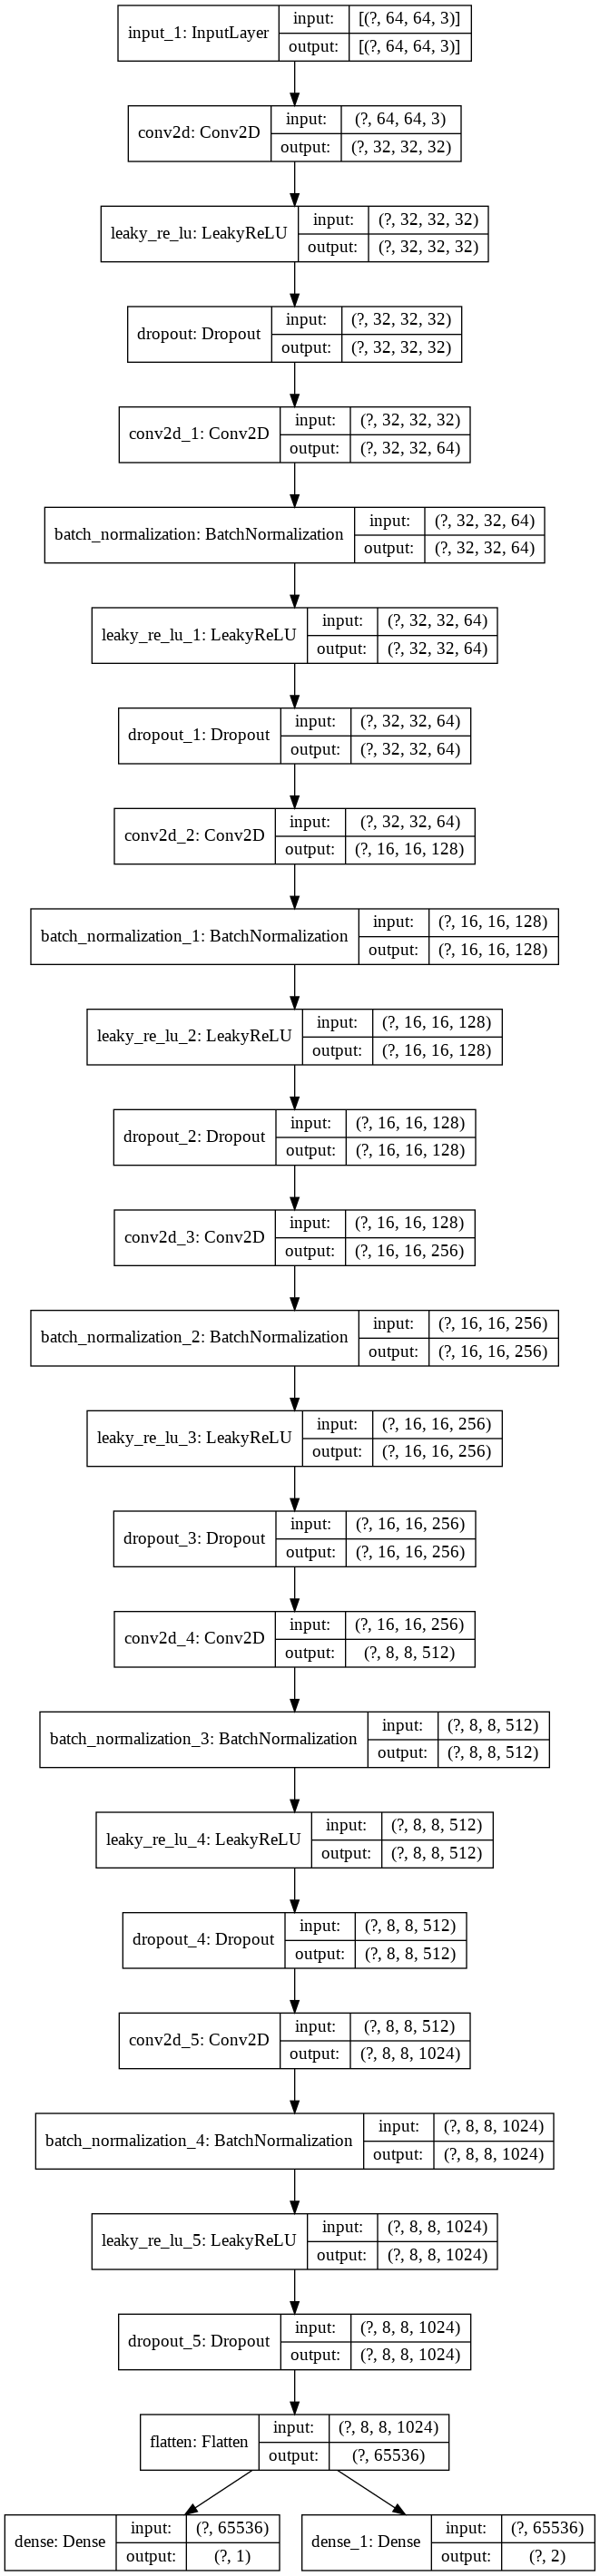

In [16]:
# Discriminator + Classifier
D = define_discriminator()

D.compile(optimizer=Adam(0.0002, 0.5), 
          loss=['binary_crossentropy', 'sparse_categorical_crossentropy'])
D.summary()
# plot the model
plot_model(D, to_file= 'discriminator_plot.png' , show_shapes=True, show_layer_names=True)

## Generator

In [0]:
# define the generator model
# 
# Reference - Paper : https://arxiv.org/pdf/1610.09585.pdf
# Also refer to GAN hacks - https://github.com/soumith/ganhacks
#
# For ACGAN:
#     inputs: label and noise (latent dimension)
#     ouput:  fake-image
#
# noise of size 8x8 -> 16x16 -> 32x32 -> 64x64
# label is also modeled as 8x8 - yet another channel along with noise
#
# Use ReLu instead of LeakyReLu for ACGAN - for more info refer to paper.
#
def generator(latent_dim, n_classes=2):

  # Input 1 - label - one dim tensor
  img_class = Input(shape=(1,))
  # use embedding for  input
  emb = Embedding(n_classes, latent_dim)(img_class)

  # setup the label as yet another channel along with noise
  n_nodes = 8 * 8
  label_in = Dense(n_nodes)(emb)
  # reshape it
  label_in = Reshape((8,8,1))(label_in)


  # Input 2 - noise
  latent_input = Input(shape=(latent_dim,))
  # foundation of noise input for image
  # refer to page 11 of the above mentioned paper for all these feature map count
  n_nodes = 398 * 8 * 8
  gen = Dense(n_nodes)(latent_input)
  gen = Activation('relu')(gen)
  gen = Reshape((8,8,398))(gen)

  # combine inputs : noise + label
  inp_merge = Concatenate()([gen, label_in])

  # upsample to 16x16
  gen = Conv2DTranspose(256, (5,5), strides=(2,2), padding='same')(inp_merge)
  gen = BatchNormalization()(gen)
  gen = Activation('relu')(gen)

  # upsample to 32x32
  gen = Conv2DTranspose(192, (5,5), strides=(2,2), padding='same')(gen)
  gen = BatchNormalization()(gen)
  gen = Activation('relu')(gen)

  # upsample to 64x64
  gen = Conv2DTranspose(3, (5,5), strides=(2,2), padding='same')(gen)
  # No BN - refer to page 11 of the above mentioned paper.

  # output
  out_layer = Activation('tanh')(gen)

  # define model
  model = Model([latent_input, img_class], out_layer)

  return model


### Instantiate Generator

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 25472)        2572672     input_3[0][0]                    
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 100)       200         input_2[

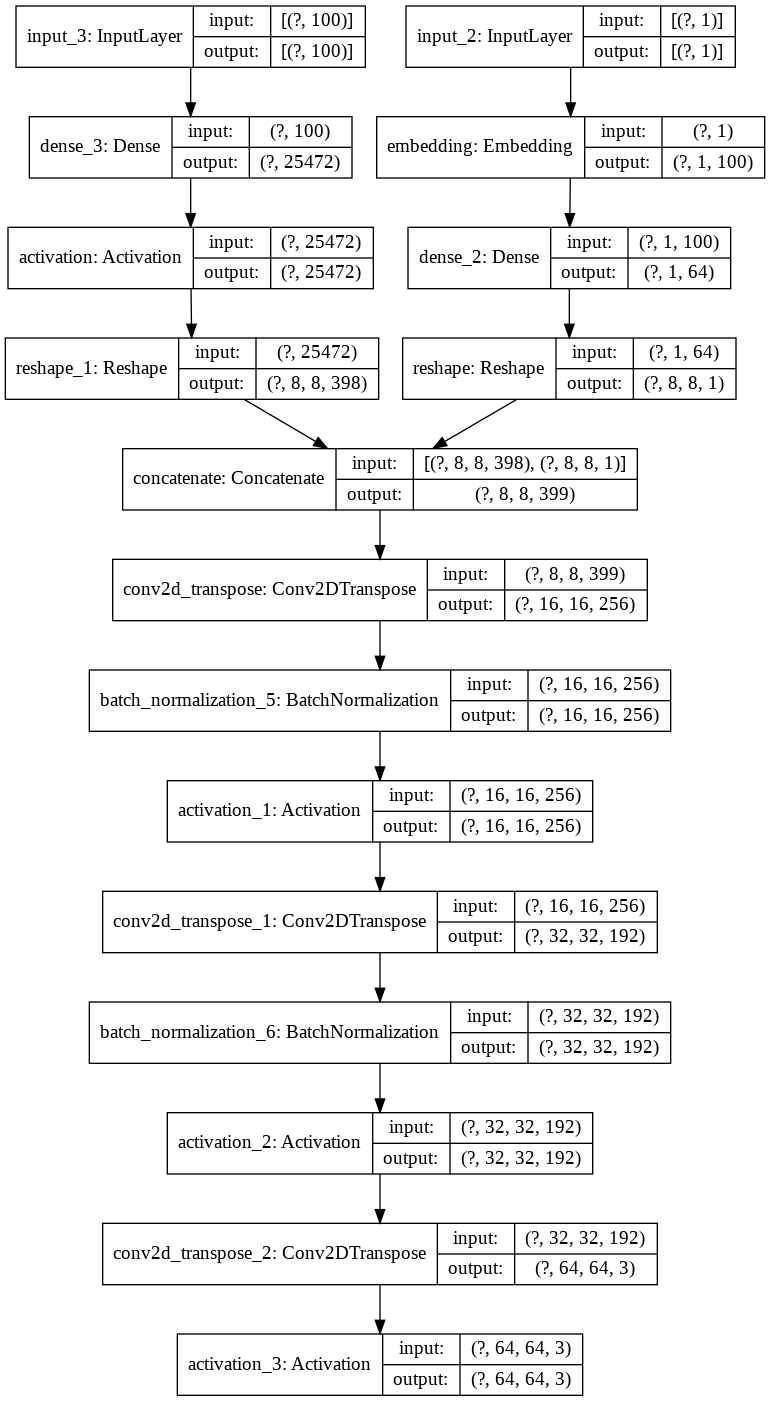

In [18]:
latent_dim = 100
G = generator(latent_dim)
G.summary()
# plot the model
plot_model(G, to_file= 'generator_plot.png' , show_shapes=True, show_layer_names=True)

## Define GAN

In [0]:
# GAN 
# input: noise
# output: generated image is fake / real
# 
# when generator is used, disable the training of discriminator
def define_gan(g_model, d_model):
  # when generator is used, disable the training of discriminator
  d_model.trainable = False

  # connect generator output to disc. input
  gan_output = d_model(g_model.output)

  #define gan model
  gan_model = Model(g_model.input, gan_output)

  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  gan_model.compile(loss=[ 'binary_crossentropy' ,  'sparse_categorical_crossentropy' ],
      optimizer=opt)
  
  return gan_model

## Traning Utilities

### Generate Real Samples

In [0]:
#def generate_real_samples(dataset, n_samples):
def generate_real_samples(trainX, trainY, n_samples):
  # split into images and labels
  images, labels = trainX, trainY

  # choose random instances
  ix = np.random.randint(0, images.shape[0], n_samples)

  # select images and labels
  X, labels = images[ix], labels[ix]

  # generate class labels
  y = np.ones((n_samples, 1))

  return [X, labels], y

### Generate Latent Points
Generate the latent space which is input to Generator

In [0]:
def generate_latent_points(latent_dim, n_samples, n_classes=2):
  # get the random points from normal distribution
  x_input = np.random.randn(latent_dim * n_samples)
  
  data = x_input.reshape(n_samples, latent_dim)
  # generate labels
  labels = np.random.randint(0, n_classes, n_samples)
  return [data, labels]


### Generate Fake Samples Using Generator
* Inputs: Latent_dim
* Outputs: images, labels and discriminator-class-label (realness value, ie 0 for fake)

In [0]:
def generate_fake_samples(generator, latent_dim, n_samples):
  # get the latent space
  data, labels_input = generate_latent_points(latent_dim, n_samples)

  # get the images and their labels
  images = generator.predict([data, labels_input])

  # tag them as fake (which is class 0 for discriminator)
  fake = np.zeros((n_samples, 1))

  return([images, labels_input], fake)

### Summarize Generator Performace

During training process measure the performace of Generator.
Just inspect the images the Generator generates at regular intervals and save the model as well.

In [0]:
# At regular intervals during training process
# generate images from generator
# and also, save model
#
def summarize_performance(step, gen_model, latent_dim, n_samples=25):
  # get the generated images
  [fake_images, _], _ = generate_fake_samples(gen_model, latent_dim, n_samples)

  # scale the images from [-1,1] to [0,1]
  fake_images = (fake_images + 1) / 2.0

  # plot images
  for i in range(25):
    plt.subplot(5, 5, 1+i)
    plt.axis('off')
    plt.imshow(fake_images[i])

  # save the plot to file
  filename = 'gen_plot_%04d.png' % (step+1)
  plt.savefig(filename)
  plt.close()

  # save the model as well
  model_file = 'gen_model_%04d.hdf5' % (step+1)
  #gen_model.save(model_file)
  print('Saved: %s and %s' % (filename, model_file))

## Training

In [0]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, trainX, trainY, latent_dim, n_epochs=100, n_batch=64):
  # calculate the number of batches per training epoch
  bat_per_epo = int(trainX.shape[0] / n_batch)

  # calculate the number of training iterations
  n_steps = bat_per_epo * n_epochs
  print('Total steps:', n_steps)

  # calculate the size of half a batch of samples
  half_batch = int(n_batch / 2)

  # manually enumerate epochs
  for i in range(n_steps):
    # get randomly selected  real  samples
    [X_real, labels_real], y_real = generate_real_samples(trainX, trainY, half_batch)

    # update discriminator model weights
    _,d_r1,d_r2 = d_model.train_on_batch(X_real, [y_real, labels_real])

    # generate  fake  examples
    [X_fake, labels_fake], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

    # update discriminator model weights
    _,d_f,d_f2 = d_model.train_on_batch(X_fake, [y_fake, labels_fake])

    # prepare points in latent space as input for the generator
    [z_input, z_labels] = generate_latent_points(latent_dim, n_batch)

    # create inverted labels for the fake samples
    y_gan = np.ones((n_batch, 1))
    # update the generator via the discriminator s error
    _,g_1,g_2 = gan_model.train_on_batch([z_input, z_labels], [y_gan, z_labels])
    
    
    if (i+1) % (bat_per_epo * 1) == 0:
      # summarize loss on this batch
      print( '>%d, dr[%.3f,%.3f], df[%.3f,%.3f], g[%.3f,%.3f]'  % 
          (i+1, d_r1,d_r2, d_f,d_f2, g_1,g_2))
      
    # evaluate the model performance every  epoch
    if (i+1) % (bat_per_epo * 10) == 0:
      summarize_performance(i, g_model, latent_dim)

In [26]:
trainX.shape[0] / 50

135.0

## Create GAN

In [0]:
gan_model = define_gan(G, D)

In [27]:
# train model
train(G, D, gan_model, trainX, trainY, latent_dim, n_epochs=10, n_batch=50)

Total steps: 1350
>135, dr[0.021,2.344], df[0.028,0.016], g[0.029,0.010]
>270, dr[0.006,1.232], df[0.003,0.006], g[0.026,0.017]
>405, dr[0.445,1.833], df[1.038,0.044], g[1.286,0.731]
>540, dr[1.883,2.576], df[2.099,0.243], g[1.907,0.399]
>675, dr[1.830,2.639], df[1.847,0.069], g[1.634,0.065]
>810, dr[0.431,1.442], df[1.388,0.088], g[1.746,0.030]
>945, dr[1.083,2.684], df[1.190,0.136], g[1.316,0.159]
>1080, dr[0.747,0.956], df[1.978,0.027], g[1.249,0.096]
>1215, dr[0.746,1.124], df[0.686,0.095], g[1.266,0.113]
>1350, dr[0.757,1.575], df[0.935,0.024], g[1.147,0.054]
Saved: gen_plot_1350.png and gen_model_1350.hdf5


In [28]:
# train model
train(G, D, gan_model, trainX, trainY, latent_dim, n_epochs=100, n_batch=50)

Total steps: 13500
>135, dr[0.817,1.255], df[0.742,0.056], g[1.260,0.126]
>270, dr[0.532,0.836], df[0.890,0.064], g[1.088,0.168]
>405, dr[0.747,0.822], df[0.903,0.042], g[0.939,0.070]
>540, dr[0.606,1.173], df[1.450,0.067], g[1.140,0.172]
>675, dr[0.727,0.922], df[1.008,0.039], g[0.952,0.049]
>810, dr[0.607,0.778], df[1.279,0.214], g[0.901,0.129]
>945, dr[1.129,1.089], df[0.432,0.025], g[1.311,0.059]
>1080, dr[0.841,0.362], df[0.951,0.027], g[1.315,0.031]
>1215, dr[0.891,0.705], df[0.699,0.030], g[0.843,0.082]
>1350, dr[0.763,1.038], df[0.655,0.076], g[1.263,0.041]
Saved: gen_plot_1350.png and gen_model_1350.hdf5
>1485, dr[0.826,0.697], df[1.083,0.081], g[1.079,0.099]
>1620, dr[0.779,0.810], df[0.750,0.086], g[1.036,0.096]
>1755, dr[0.629,1.230], df[0.676,0.168], g[0.879,0.077]
>1890, dr[0.588,1.053], df[0.585,0.073], g[0.678,0.168]
>2025, dr[0.688,0.690], df[0.546,0.047], g[1.047,0.049]
>2160, dr[0.608,0.848], df[0.600,0.057], g[1.091,0.038]
>2295, dr[0.709,0.310], df[1.395,0.171], g[

In [0]:
!mkdir run1

In [0]:
!mv *.png run1

## Train some more

In [31]:
trainX.shape

(6750, 64, 64, 3)

In [32]:
# train model
train(G, D, gan_model, trainX, trainY, latent_dim, n_epochs=50, n_batch=250)

Total steps: 1350
>27, dr[0.463,0.494], df[0.494,0.041], g[1.322,0.064]
>54, dr[0.303,0.480], df[0.524,0.074], g[1.467,0.079]
>81, dr[0.556,0.381], df[0.512,0.088], g[1.300,0.112]
>108, dr[0.436,0.358], df[0.465,0.044], g[1.456,0.083]
>135, dr[0.716,0.310], df[0.622,0.053], g[1.282,0.058]
>162, dr[0.600,0.536], df[0.547,0.035], g[1.274,0.081]
>189, dr[0.387,0.370], df[0.685,0.166], g[1.950,0.087]
>216, dr[0.461,0.379], df[0.738,0.046], g[1.483,0.063]
>243, dr[0.530,0.371], df[0.414,0.091], g[1.345,0.077]
>270, dr[0.485,0.505], df[0.603,0.048], g[1.532,0.090]
Saved: gen_plot_0270.png and gen_model_0270.hdf5
>297, dr[0.456,0.423], df[0.643,0.074], g[1.549,0.085]
>324, dr[0.600,0.378], df[0.615,0.100], g[1.774,0.100]
>351, dr[0.384,0.442], df[0.358,0.161], g[1.323,0.109]
>378, dr[0.564,0.396], df[0.588,0.037], g[1.397,0.082]
>405, dr[0.718,0.446], df[0.437,0.077], g[1.483,0.075]
>432, dr[0.608,0.405], df[0.506,0.074], g[1.968,0.085]
>459, dr[0.449,0.413], df[0.589,0.067], g[1.279,0.080]
>

In [0]:
!mkdir run2

In [0]:
!mv *.png run2

## Train more

In [35]:
# train model
train(G, D, gan_model, trainX, trainY, latent_dim, n_epochs=100, n_batch=50)

Total steps: 13500
>135, dr[0.462,1.317], df[0.294,0.974], g[0.949,0.123]
>270, dr[0.519,0.378], df[1.024,0.203], g[1.828,0.077]
>405, dr[0.861,0.876], df[0.903,0.028], g[1.913,0.359]
>540, dr[0.487,0.338], df[0.358,0.023], g[1.980,0.104]
>675, dr[0.283,0.567], df[1.212,0.116], g[1.332,0.046]
>810, dr[1.046,0.574], df[0.528,0.041], g[1.001,0.143]
>945, dr[0.233,0.239], df[0.303,0.083], g[1.714,0.120]
>1080, dr[0.067,0.401], df[0.298,0.075], g[0.901,0.092]
>1215, dr[0.273,0.485], df[0.646,0.055], g[2.256,0.188]
>1350, dr[0.524,0.800], df[0.360,0.075], g[1.305,0.072]
Saved: gen_plot_1350.png and gen_model_1350.hdf5
>1485, dr[0.271,0.752], df[0.543,0.032], g[2.082,0.068]
>1620, dr[0.735,0.574], df[0.652,0.009], g[1.621,0.050]
>1755, dr[0.825,0.103], df[0.454,0.073], g[1.740,0.085]
>1890, dr[0.639,0.363], df[0.752,0.305], g[2.170,0.113]
>2025, dr[1.816,0.285], df[0.864,0.084], g[1.528,0.136]
>2160, dr[0.411,0.816], df[0.363,0.147], g[1.211,0.059]
>2295, dr[0.980,0.726], df[0.347,0.085], g[

In [0]:
!mkdir run3
!mv *.png run3

In [0]:
gan_model.save('gan_model.hdf5')
D.save('D_model.hdf5')
G.save('G_model.hdf5')

In [0]:
!mv *.hdf5 run3

## Train some more

In [39]:
# train model
train(G, D, gan_model, trainX, trainY, latent_dim, n_epochs=200, n_batch=50)

Total steps: 27000
>135, dr[0.336,0.238], df[0.166,0.024], g[1.493,0.023]
>270, dr[0.765,0.369], df[0.897,0.068], g[1.676,0.066]
>405, dr[0.356,0.508], df[0.554,0.024], g[1.766,0.134]
>540, dr[0.738,0.374], df[0.924,0.073], g[0.722,0.097]
>675, dr[0.552,0.362], df[0.595,0.201], g[1.964,0.039]
>810, dr[0.144,0.433], df[0.560,0.079], g[3.150,0.110]
>945, dr[0.515,0.294], df[0.472,0.041], g[1.553,0.140]
>1080, dr[0.738,0.050], df[0.666,0.043], g[1.452,0.023]
>1215, dr[0.384,0.403], df[0.435,0.087], g[1.885,0.099]
>1350, dr[0.253,0.100], df[0.277,0.014], g[2.481,0.049]
Saved: gen_plot_1350.png and gen_model_1350.hdf5
>1485, dr[0.031,0.369], df[0.843,0.313], g[1.763,0.058]
>1620, dr[1.256,0.188], df[0.939,0.035], g[1.370,0.100]
>1755, dr[0.472,0.098], df[0.363,0.111], g[1.870,0.159]
>1890, dr[0.600,0.531], df[0.142,0.065], g[1.805,0.048]
>2025, dr[1.189,0.470], df[0.854,0.155], g[1.654,0.141]
>2160, dr[0.610,0.156], df[0.717,0.042], g[1.212,0.030]
>2295, dr[0.370,0.369], df[0.163,0.253], g[

In [0]:
!mkdir run4
!mv *.png run4

In [0]:
gan_model.save('gan_model.hdf5')
D.save('D_model.hdf5')
G.save('G_model.hdf5')

In [0]:
!mv *.hdf5 run4